In [38]:
import cv2
import os
import warnings
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import platform
import numpy as np
from utils import plot_image

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

%matplotlib inline
%reload_ext nb_black
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
CUSTOM_MODEL_NAME = "my_ssd_mobnet"
PRETRAINED_MODEL_NAME = "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
PRETRAINED_MODEL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz"
TF_RECORD_SCRIPT_NAME = "generate_tfrecord.py"
LABEL_MAP_NAME = "label_map.pbtxt"
current_os = platform.system()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
parent_directory = os.path.dirname(os.getcwd())
paths = {
    "SRC_PATH": os.path.join(parent_directory, "src"),
    "DATA_PATH": os.path.join(parent_directory, "data"),
    "APIMODEL_PATH": os.path.join(parent_directory, "api_models"),
    "MODEL_PATH": os.path.join(parent_directory, "my_models"),
    "PRETRAINED_MODEL_PATH": os.path.join(parent_directory, "pre-trained-models"),
    "CHECKPOINT_PATH": os.path.join(parent_directory, "my_models", CUSTOM_MODEL_NAME),
    "OUTPUT_PATH": os.path.join(
        parent_directory, "my_models", CUSTOM_MODEL_NAME, "export"
    ),
    "TFJS_PATH": os.path.join(
        parent_directory, "my_models", CUSTOM_MODEL_NAME, "tfjsexport"
    ),
    "TFLITE_PATH": os.path.join(
        parent_directory, "my_models", CUSTOM_MODEL_NAME, "tfliteexport"
    ),
    "PROTOC_PATH": os.path.join(parent_directory, "protoc"),
    "VIDEOS_PATH": os.path.join(parent_directory, "videos"),
}
mice = [
    "PrL-2",
    "PrL-3",
    "PrL-4",
    "PrL-5",
    "PrL-8",
    "PrL-9",
    "PrL-10",
    "PrL-16",
    "PrL-19",
]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
files = {
    "PIPELINE_CONFIG": os.path.join(
        parent_directory, "my_models", CUSTOM_MODEL_NAME, "pipeline.config"
    ),
    "TF_RECORD_SCRIPT": os.path.join(paths["DATA_PATH"], TF_RECORD_SCRIPT_NAME),
    "LABELMAP": os.path.join(paths["DATA_PATH"], LABEL_MAP_NAME),
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files["PIPELINE_CONFIG"])
detection_model = model_builder.build(model_config=configs["model"], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths["CHECKPOINT_PATH"], "ckpt-3")).expect_partial()


@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
category_index = label_map_util.create_category_index_from_labelmap(files["LABELMAP"])
category_index

{1: {'id': 1, 'name': 'parent-mice'}, 2: {'id': 2, 'name': 'child-mice'}}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
IMAGE_PATH = (
    f'{paths["DATA_PATH"]}/train/parent_PrL-4-0f93312b-0d14-4741-baa5-a82fe96d695f.jpg'
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
def sharpen_image(img):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    im = cv2.filter2D(img, -1, kernel)
    return im

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
0.5 not in range(0, 1)

True

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
def detect_pup_mouse(image_np: np.ndarray, min_thresh=0.3):
    if min_thresh < 0 or min_thresh > 1:
        raise ValueError("min_thresh score should be between 0 and 1 inclusive")
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop("num_detections"))
    detections = {
        key: np.asarray(value[0, :num_detections]) for key, value in detections.items()
    }
    detections["num_detections"] = num_detections

    # detection_classes should be ints.
    detections["detection_classes"] = detections["detection_classes"].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections["detection_boxes"],
        detections["detection_classes"] + label_id_offset,
        detections["detection_scores"],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=2,
        min_score_thresh=min_thresh,
        agnostic_mode=False,
    )
    return detections, image_np_with_detections

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
watch_video = False
cap = cv2.VideoCapture(f'{paths["VIDEOS_PATH"]}/PrL-9.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while watch_video and cap.isOpened():
    ret, frame = cap.read()
    image_np = np.array(frame)

    detections, image_np_with_detections = detect_pup_mouse(image_np)

    cv2.imshow("object detection", cv2.resize(image_np_with_detections, (800, 600)))

    client_key_press = cv2.waitKey(1) & 0xFF

    # end video stream by escape key
    if client_key_press == 27:
        break
cap.release()  # Important: release current active webcam or stream in order for other instance of webcam
cv2.destroyAllWindows()
if platform == "darwin":
    cv2.waitKey(1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
detections, image_np_with_detections = detect_pup_mouse(img_arr)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

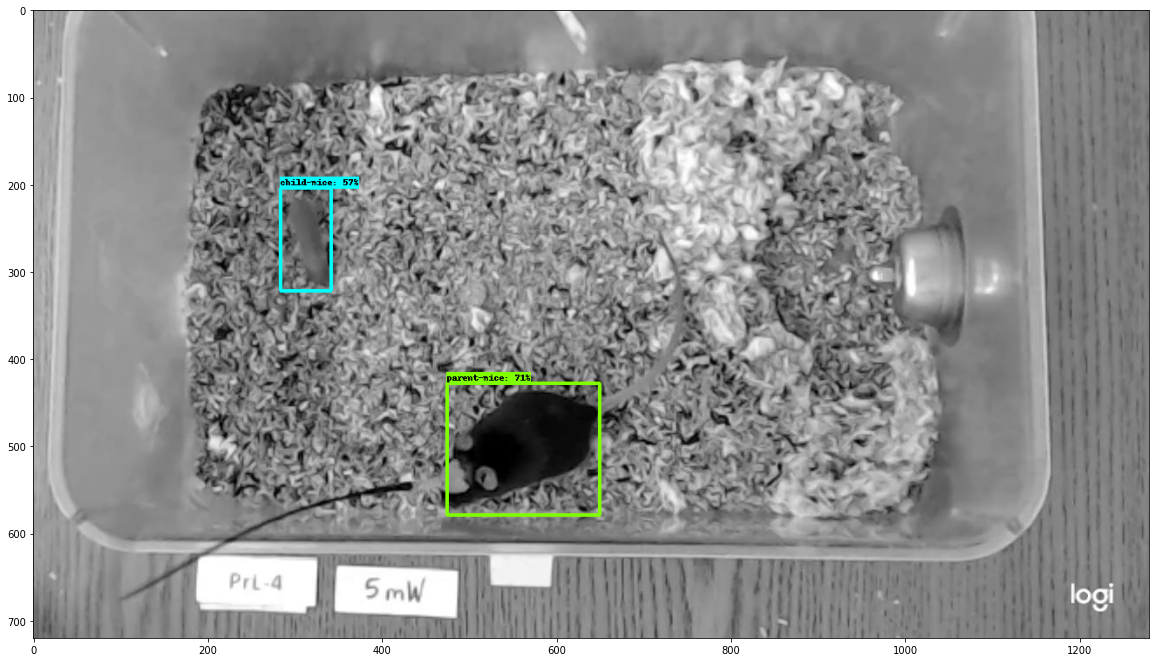

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
plot_image(image_np_with_detections)

In [51]:
detections

{'detection_boxes': array([[0.5953765 , 0.37087363, 0.80315113, 0.5083275 ],
        [0.2833855 , 0.2215306 , 0.44663134, 0.2672565 ],
        [0.6236763 , 0.34793878, 0.79633796, 0.5518901 ],
        [0.        , 0.05687275, 0.3583157 , 0.18310934],
        [0.6554652 , 0.3958693 , 0.7554    , 0.4821427 ],
        [0.5994169 , 0.35800937, 0.80389124, 0.5223736 ],
        [0.6413599 , 0.79030323, 0.99394715, 0.9321456 ],
        [0.6554652 , 0.3958693 , 0.7554    , 0.4821427 ],
        [0.2833855 , 0.2215306 , 0.44663134, 0.2672565 ],
        [0.32103118, 0.21621814, 0.43375972, 0.27526653],
        [0.23978314, 0.20355509, 0.48443332, 0.28448793],
        [0.6452595 , 0.33323658, 0.7764418 , 0.5146445 ],
        [0.80989766, 0.940621  , 1.        , 1.        ],
        [0.8146569 , 0.        , 1.        , 0.15099338],
        [0.60787845, 0.76196754, 0.9697374 , 0.8937204 ],
        [0.878731  , 0.5920432 , 0.99476314, 0.6429115 ],
        [0.6227294 , 0.3540007 , 0.8174019 , 0.480873

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
{'detection_boxes': array([[0.5953765 , 0.37087363, 0.80315113, 0.5083275 ],
        [0.2833855 , 0.2215306 , 0.44663134, 0.2672565 ],
        [0.6236763 , 0.34793878, 0.79633796, 0.5518901 ],
        [0.        , 0.05687275, 0.3583157 , 0.18310934],
        [0.6554652 , 0.3958693 , 0.7554    , 0.4821427 ],
        [0.5994169 , 0.35800937, 0.80389124, 0.5223736 ],
        [0.6413599 , 0.79030323, 0.99394715, 0.9321456 ],
        [0.6554652 , 0.3958693 , 0.7554    , 0.4821427 ],
        [0.2833855 , 0.2215306 , 0.44663134, 0.2672565 ],
        [0.32103118, 0.21621814, 0.43375972, 0.27526653],
        [0.23978314, 0.20355509, 0.48443332, 0.28448793],
        [0.6452595 , 0.33323658, 0.7764418 , 0.5146445 ],
        [0.80989766, 0.940621  , 1.        , 1.        ],
        [0.8146569 , 0.        , 1.        , 0.15099338],
        [0.60787845, 0.76196754, 0.9697374 , 0.8937204 ],
        [0.878731  , 0.5920432 , 0.99476314, 0.6429115 ],
        [0.6227294 , 0.3540007 , 0.8174019 , 0.48087388],
        [0.67581534, 0.38114083, 0.7433921 , 0.46085578],
        [0.5483084 , 0.35913306, 0.92187643, 0.48903704],
        [0.        , 0.07119515, 0.26952022, 0.2458739 ],
        [0.6074815 , 0.29395157, 0.8145164 , 0.5783647 ],
        [0.3508761 , 0.20758444, 0.41146672, 0.28271407],
        [0.27520633, 0.1777074 , 0.4771973 , 0.29766065],
        [0.6400542 , 0.3826189 , 0.7347394 , 0.46285093],
        [0.5996204 , 0.32952142, 0.76048785, 0.5298091 ],
        [0.7344092 , 0.7532253 , 0.98166287, 0.9305022 ],
        [0.        , 0.05614049, 0.25624406, 0.19733277],
        [0.6394967 , 0.43605492, 0.76057374, 0.4979091 ],
        [0.69244003, 0.37332442, 0.7600633 , 0.45326355],
        [0.776169  , 0.76501596, 0.9515639 , 0.9772798 ],
        [0.86332667, 0.9594225 , 1.        , 1.        ],
        [0.        , 0.09079297, 0.22966807, 0.2425765 ],
        [0.        , 0.7555745 , 0.25268012, 0.91445047],
        [0.8540179 , 0.94203526, 1.        , 0.9874601 ],
        [0.6063959 , 0.40816045, 0.8161474 , 0.5737573 ],
        [0.6644283 , 0.37686944, 0.75515884, 0.44950294],
        [0.3113299 , 0.13841608, 0.43703735, 0.3203248 ],
        [0.6434723 , 0.37597093, 0.7162894 , 0.47985837],
        [0.7829015 , 0.8849143 , 1.        , 1.        ],
        [0.36051372, 0.20952958, 0.42422953, 0.2972378 ],
        [0.86332667, 0.9594225 , 1.        , 1.        ],
        [0.3333041 , 0.20940575, 0.3943953 , 0.28279006],
        [0.3695028 , 0.19795011, 0.4294987 , 0.27366093],
        [0.91849136, 0.9511322 , 1.        , 1.        ],
        [0.8368851 , 0.13175249, 0.9904287 , 0.28911135],
        [0.01071984, 0.13785861, 0.14799565, 0.34322935],
        [0.03338258, 0.43186074, 0.09264657, 0.50970656],
        [0.76408964, 0.78870827, 1.        , 0.95263225],
        [0.8659477 , 0.92477345, 1.        , 1.        ],
        [0.6452451 , 0.37053564, 0.71082807, 0.46987042],
        [0.04265081, 0.01981658, 0.22194263, 0.22582734],
        [0.78324366, 0.9184904 , 1.        , 1.        ],
        [0.9043665 , 0.5805522 , 0.9693624 , 0.66143966],
        [0.92803013, 0.93130577, 0.98898304, 1.        ],
        [0.5913965 , 0.32670876, 0.8731399 , 0.5119631 ],
        [0.        , 0.7926889 , 0.23095447, 0.9408366 ],
        [0.79077226, 0.8564811 , 0.98321563, 1.        ],
        [0.91836125, 0.9365304 , 1.        , 0.99888796],
        [0.57512987, 0.405173  , 0.85146976, 0.52787954],
        [0.6417631 , 0.2705187 , 0.8010855 , 0.43901566],
        [0.        , 0.05597369, 0.18050255, 0.26085734],
        [0.904657  , 0.5636206 , 0.96623063, 0.6411336 ],
        [0.65673983, 0.43460596, 0.767007  , 0.50275403],
        [0.6701118 , 0.3243612 , 0.82033575, 0.50615525],
        [0.6842501 , 0.3910639 , 0.753178  , 0.4976698 ],
        [0.8666849 , 0.05111705, 0.9645802 , 0.12329547],
        [0.75722945, 0.93763435, 0.9811541 , 1.        ],
        [0.6596517 , 0.37348676, 0.72493976, 0.45519507],
        [0.8752047 , 0.08110335, 0.98925555, 0.13836895],
        [0.6276006 , 0.38426483, 0.7006127 , 0.48115587],
        [0.73770314, 0.82237744, 1.        , 1.        ],
        [0.641692  , 0.3866001 , 0.75216705, 0.45648465],
        [0.        , 0.9417868 , 0.13443153, 1.        ],
        [0.05886588, 0.2191472 , 0.12000147, 0.3096419 ],
        [0.        , 0.9398622 , 0.2040324 , 1.        ],
        [0.        , 0.8931885 , 0.21035175, 1.        ],
        [0.58371276, 0.3821458 , 0.74832934, 0.55524284],
        [0.32103118, 0.21621814, 0.43375972, 0.27526653],
        [0.01098216, 0.09119884, 0.3892902 , 0.22140142],
        [0.07302676, 0.05291937, 0.4399922 , 0.17843589],
        [0.626753  , 0.41765398, 0.7883426 , 0.48559648],
        [0.0336208 , 0.73272353, 0.20900661, 0.9337726 ],
        [0.7261612 , 0.87518746, 1.        , 1.        ],
        [0.        , 0.7739993 , 0.22144747, 0.8850681 ],
        [0.91849136, 0.9511322 , 1.        , 1.        ],
        [0.6596517 , 0.37348676, 0.72493976, 0.45519507],
        [0.88158154, 0.16774182, 0.9428719 , 0.25280073],
        [0.05886588, 0.2191472 , 0.12000147, 0.3096419 ],
        [0.6415889 , 0.40863517, 0.71828055, 0.4875464 ],
        [0.9272643 , 0.90848285, 0.98693997, 0.9929102 ],
        [0.645823  , 0.37217623, 0.74283004, 0.44072813],
        [0.626753  , 0.41765398, 0.7883426 , 0.48559648],
        [0.6842501 , 0.3910639 , 0.753178  , 0.4976698 ],
        [0.6237925 , 0.3933863 , 0.7815275 , 0.47054994],
        [0.7029116 , 0.34481615, 0.7636297 , 0.41556567],
        [0.        , 0.09105283, 0.14214343, 0.291027  ],
        [0.31499085, 0.2011228 , 0.3750128 , 0.27323645],
        [0.92387235, 0.561477  , 0.98363423, 0.6381739 ],
        [0.        , 0.7632755 , 0.17720899, 0.96694016],
        [0.604619  , 0.7779113 , 0.89330435, 0.94565344]], dtype=float32),
 'detection_scores': array([0.70907086, 0.5741756 , 0.25201914, 0.1523116 , 0.15029144,
        0.14870557, 0.14731905, 0.14459792, 0.11788028, 0.11557987,
        0.10205302, 0.09585026, 0.093885  , 0.09009761, 0.08978835,
        0.07505068, 0.07152516, 0.06244323, 0.05976757, 0.0590584 ,
        0.05725586, 0.05718783, 0.05697367, 0.05636039, 0.05532727,
        0.0549762 , 0.05451065, 0.05388644, 0.05349073, 0.05187532,
        0.0508903 , 0.04841354, 0.04359573, 0.04259694, 0.04169512,
        0.04100713, 0.04057541, 0.04035738, 0.04010391, 0.04003128,
        0.0396094 , 0.03894407, 0.03890181, 0.03887218, 0.03875846,
        0.03821415, 0.03797346, 0.03774667, 0.03711489, 0.03707823,
        0.03699997, 0.03672507, 0.03651425, 0.03644103, 0.03619143,
        0.03607213, 0.03593528, 0.03461063, 0.03415316, 0.0340502 ,
        0.03388351, 0.03380197, 0.03313059, 0.03310665, 0.03287041,
        0.03274623, 0.03187034, 0.03133518, 0.03112519, 0.0309051 ,
        0.03083119, 0.03039369, 0.02998075, 0.02994123, 0.02986404,
        0.02955201, 0.02943513, 0.02925274, 0.02913618, 0.02889612,
        0.02858791, 0.02792197, 0.02773523, 0.02756733, 0.02725452,
        0.02708635, 0.02646452, 0.02644229, 0.02629089, 0.02615991,
        0.02588484, 0.02574092, 0.02553859, 0.0254381 , 0.02442512,
        0.02422881, 0.0239529 , 0.02378705, 0.02364007, 0.02335608],
       dtype=float32),
 'detection_classes': array([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0]),
 'raw_detection_boxes': array([[-0.03720095, -0.01800546,  0.06552341,  0.04524095],
        [-0.08345009, -0.04410864,  0.10949878,  0.07901818],
        [-0.02248871, -0.03208172,  0.04493487,  0.06672931],
        [-0.04963711, -0.0862641 ,  0.06950185,  0.11084177],
        [-0.05112077, -0.01271385,  0.07958055,  0.03923809],
        [-0.10287109, -0.03511389,  0.13010785,  0.06180333],
        [-0.03132569,  0.00805377,  0.06421592,  0.07009696],
        [-0.08277301, -0.02015565,  0.11461523,  0.10630795],
        [-0.01998255, -0.00433379,  0.04430971,  0.08752318],
        [-0.05350332, -0.05784862,  0.07154644,  0.13705993],
        [-0.04436772,  0.01343345,  0.07755288,  0.06480671],
        [-0.09769493, -0.008377  ,  0.13210243,  0.08965237],
        [-0.03050231,  0.03089817,  0.06463082,  0.09577002],
        [-0.08216622,  0.00268853,  0.11736324,  0.1332292 ],
        [-0.01939529,  0.01759686,  0.04466828,  0.11174795],
        [-0.05327389, -0.03344578,  0.0731207 ,  0.16279748],
        [-0.04414899,  0.03662847,  0.07929997,  0.09013301],
        [-0.09721296,  0.01512654,  0.13574618,  0.11704157],
        [-0.03147151,  0.0555306 ,  0.06922378,  0.11955772],
        [-0.08354127,  0.02841105,  0.12659755,  0.15561417],
        [-0.01834962,  0.04021083,  0.04516467,  0.13434108],
        [-0.05192592, -0.00943595,  0.07463411,  0.18790609],
        [-0.04764734,  0.06165747,  0.08646466,  0.11405328],
        [-0.10352283,  0.04121962,  0.15130632,  0.1402902 ],
        [-0.03155598,  0.08021896,  0.07420461,  0.14310667],
        [-0.08430642,  0.05410341,  0.13532595,  0.17814764],
        [-0.01742079,  0.06245355,  0.04583863,  0.15639539],
        [-0.04924744,  0.01419871,  0.07664543,  0.21195526],
        [-0.05007219,  0.0862727 ,  0.09500924,  0.13799624],
        [-0.10943942,  0.06706432,  0.1673253 ,  0.16292214],
        [-0.02958159,  0.10412691,  0.07466337,  0.1674197 ],
        [-0.08250886,  0.0762045 ,  0.13581271,  0.20179337],
        [-0.01669743,  0.08514561,  0.04665873,  0.18027727],
        [-0.04761004,  0.03634182,  0.07792046,  0.23580924],
        [-0.04825353,  0.11017924,  0.0974495 ,  0.16332376],
        [-0.10621285,  0.08956647,  0.16907868,  0.18751213],
        [-0.02998203,  0.12835641,  0.07393742,  0.19196291],
        [-0.08118665,  0.09787036,  0.13265602,  0.22546642],
        [-0.01727622,  0.10975033,  0.04587734,  0.20538494],
        [-0.04802811,  0.0580337 ,  0.07685824,  0.25903952],
        [-0.0476747 ,  0.13494612,  0.09682061,  0.1884818 ],
        [-0.10516242,  0.11152403,  0.1661123 ,  0.21162377],
        [-0.03284111,  0.15381117,  0.0756616 ,  0.21615176],
        [-0.08262477,  0.1236961 ,  0.13436812,  0.24915129],
        [-0.01842081,  0.13491535,  0.04465656,  0.23010665],
        [-0.04820765,  0.08056886,  0.07533848,  0.2827428 ],
        [-0.05074146,  0.16031447,  0.09932368,  0.21230236],
        [-0.11033137,  0.13704336,  0.17075203,  0.2344462 ],
        [-0.03696915,  0.18001047,  0.08178759,  0.23951629],
        [-0.08630403,  0.15131152,  0.14363766,  0.2711767 ],
        [-0.01916853,  0.15902303,  0.04446185,  0.25434515],
        [-0.04662718,  0.1034385 ,  0.07553055,  0.30714792],
        [-0.05626411,  0.18618897,  0.10933473,  0.23520187],
        [-0.11980963,  0.1647588 ,  0.18571156,  0.25618416],
        [-0.04197354,  0.20594609,  0.09121826,  0.262742  ],
        [-0.09177274,  0.1782469 ,  0.1566017 ,  0.29112136],
        [-0.01957614,  0.1823608 ,  0.04530324,  0.27818212],
        [-0.04407951,  0.12801865,  0.07710718,  0.3313269 ],
        [-0.06248396,  0.21225627,  0.12450252,  0.25868544],
        [-0.13008073,  0.19247803,  0.20373002,  0.2775788 ],
        [-0.04513637,  0.23081094,  0.09664302,  0.28688926],
        [-0.09534148,  0.20383279,  0.16249236,  0.31243372],
        [-0.01972744,  0.2061037 ,  0.04631889,  0.30246055],
        [-0.04274658,  0.15549849,  0.07802267,  0.35559392],
        [-0.06532964,  0.23775946,  0.13254622,  0.2834435 ],
        [-0.13285664,  0.21859466,  0.208525  ,  0.3010127 ],
        [-0.04384275,  0.25496006,  0.09228101,  0.31263733],
        [-0.09405138,  0.2281045 ,  0.15491761,  0.33832285],
        [-0.0196465 ,  0.23169188,  0.0466468 ,  0.3285605 ],
        [-0.04422923,  0.18457925,  0.07707039,  0.38087952],
        [-0.06171367,  0.26245645,  0.12424587,  0.3092024 ],
        [-0.12498207,  0.24265449,  0.19356224,  0.32786393],
        [-0.04093131,  0.27966708,  0.08364245,  0.33965915],
        [-0.09080528,  0.2529208 ,  0.14153957,  0.36769938],
        [-0.01966358,  0.2596005 ,  0.04599073,  0.3558078 ],
        [-0.0471967 ,  0.21286932,  0.07497672,  0.40665898],
        [-0.05651263,  0.28721997,  0.10858344,  0.3357019 ],
        [-0.11599408,  0.26656294,  0.17291902,  0.35648245],
        [-0.03870425,  0.30484614,  0.07723318,  0.36659792],
        [-0.08813344,  0.27817366,  0.13161395,  0.39656547],
        [-0.0198506 ,  0.2875054 ,  0.04500859,  0.38223076],
        [-0.04954742,  0.23961973,  0.07309982,  0.43162304],
        [-0.05319225,  0.31211573,  0.09665259,  0.36214077],
        [-0.11096006,  0.29079875,  0.15843982,  0.38410464],
        [-0.03708132,  0.3299193 ,  0.07332002,  0.3928623 ],
        [-0.08631384,  0.30296668,  0.12518637,  0.42400488],
        [-0.0198003 ,  0.31431475,  0.04432253,  0.4080349 ],
        [-0.0511229 ,  0.26520064,  0.07177242,  0.4565306 ],
        [-0.05143689,  0.33709976,  0.08952843,  0.38801566],
        [-0.10841313,  0.31483957,  0.14976138,  0.41038767],
        [-0.03718989,  0.35483697,  0.07122129,  0.4180611 ],
        [-0.08526203,  0.32722232,  0.12088257,  0.45103154],
        [-0.02008203,  0.34047475,  0.04448034,  0.4345623 ],
        [-0.05247268,  0.2880084 ,  0.07114633,  0.48122972],
        [-0.0509672 ,  0.3617761 ,  0.08529194,  0.41269672],
        [-0.10804275,  0.3386739 ,  0.14486477,  0.4355303 ],
        [-0.03953432,  0.38032538,  0.07385142,  0.44292933],
        [-0.0859128 ,  0.35256684,  0.12381706,  0.47588485],
        [-0.02061436,  0.36632687,  0.04586192,  0.4614455 ],
        [-0.05208392,  0.30998075,  0.07178894,  0.5054256 ]],
       dtype=float32),
 'raw_detection_scores': array([[0.00372258, 0.00292009, 0.00548065],
        [0.00304145, 0.00517827, 0.00287345],
        [0.00430182, 0.00285706, 0.00446448],
        [0.00386176, 0.00478283, 0.00354981],
        [0.00439006, 0.00303286, 0.00841066],
        [0.00357163, 0.00779215, 0.00436345],
        [0.00321797, 0.00111783, 0.00351718],
        [0.00213242, 0.00208214, 0.00212127],
        [0.00274673, 0.00168636, 0.00280768],
        [0.00262854, 0.00308123, 0.00248671],
        [0.00291285, 0.00061005, 0.00552928],
        [0.0025894 , 0.00184655, 0.00344554],
        [0.00340199, 0.00123355, 0.00320804],
        [0.00219676, 0.00271219, 0.00225717],
        [0.0027732 , 0.00176445, 0.00240058],
        [0.00254166, 0.00370148, 0.00259167],
        [0.00293258, 0.00067416, 0.00520396],
        [0.00263381, 0.00244874, 0.00345379],
        [0.00379345, 0.00140652, 0.00295883],
        [0.00264123, 0.00362039, 0.00255042],
        [0.00296903, 0.00176093, 0.00226864],
        [0.00259161, 0.00451443, 0.0028758 ],
        [0.00330499, 0.00107524, 0.00581884],
        [0.00299081, 0.00435883, 0.00367486],
        [0.00414023, 0.00171867, 0.00300953],
        [0.00307482, 0.0050528 , 0.00293511],
        [0.0032146 , 0.00184923, 0.00233072],
        [0.0027422 , 0.00551054, 0.00310457],
        [0.00389722, 0.00174433, 0.00655189],
        [0.00348669, 0.00787297, 0.00394502],
        [0.00420567, 0.00197622, 0.00315967],
        [0.0031184 , 0.00645185, 0.00307363],
        [0.00328121, 0.00201535, 0.0023638 ],
        [0.00282231, 0.00653586, 0.00308079],
        [0.00411165, 0.00202528, 0.00644061],
        [0.0036796 , 0.01003206, 0.00410199],
        [0.00426242, 0.00181687, 0.0029892 ],
        [0.00311345, 0.00621536, 0.00295264],
        [0.00332829, 0.00193927, 0.00227717],
        [0.00264421, 0.00690344, 0.00301823],
        [0.00407156, 0.00194198, 0.00597787],
        [0.00375786, 0.00968623, 0.00416547],
        [0.00451893, 0.00156769, 0.00259331],
        [0.00329942, 0.00526944, 0.00288007],
        [0.00350904, 0.00173771, 0.00205198],
        [0.0024271 , 0.00671563, 0.00301063],
        [0.00417978, 0.00204051, 0.00584373],
        [0.00392953, 0.00892839, 0.00423005],
        [0.00502995, 0.00138119, 0.00220546],
        [0.00377637, 0.00434855, 0.00296852],
        [0.00394699, 0.00151688, 0.00177193],
        [0.0022653 , 0.00656551, 0.00320631],
        [0.00456914, 0.00251046, 0.00591958],
        [0.004388  , 0.00887257, 0.00440717],
        [0.00560331, 0.00125769, 0.00191885],
        [0.00436461, 0.00372741, 0.0031637 ],
        [0.00448117, 0.00136802, 0.00153708],
        [0.0021936 , 0.00624871, 0.00359288],
        [0.00506434, 0.00311896, 0.00583375],
        [0.0049116 , 0.00922173, 0.0045754 ],
        [0.00564849, 0.001221  , 0.00184062],
        [0.00447974, 0.00360075, 0.00335735],
        [0.00469139, 0.00131696, 0.00146538],
        [0.00226623, 0.00566915, 0.00372428],
        [0.00517491, 0.00321123, 0.00556946],
        [0.0050042 , 0.00935802, 0.00464034],
        [0.00505072, 0.0011954 , 0.00193959],
        [0.00392443, 0.00367674, 0.00325516],
        [0.00434747, 0.00129339, 0.0015257 ],
        [0.00243828, 0.00502068, 0.00342295],
        [0.00458518, 0.00241202, 0.00515845],
        [0.00443766, 0.0081957 , 0.00449485],
        [0.00438187, 0.00112584, 0.00205368],
        [0.00322619, 0.00347987, 0.00289124],
        [0.00367963, 0.00129643, 0.00161222],
        [0.0024572 , 0.0044511 , 0.00300565],
        [0.00390831, 0.0015009 , 0.00471708],
        [0.00365365, 0.00616676, 0.00403413],
        [0.00396532, 0.00107318, 0.00215933],
        [0.00280038, 0.00323382, 0.00257802],
        [0.00313637, 0.0013409 , 0.00174525],
        [0.00244471, 0.00406978, 0.00271642],
        [0.00344363, 0.00102332, 0.00447366],
        [0.00307167, 0.00478011, 0.00359386],
        [0.00371251, 0.00106913, 0.00227001],
        [0.00258648, 0.00317675, 0.00242627],
        [0.00281671, 0.00140902, 0.00188521],
        [0.00247055, 0.00384635, 0.00256991],
        [0.00322285, 0.00083253, 0.00437471],
        [0.00276566, 0.00422743, 0.00334108],
        [0.0037286 , 0.00109914, 0.00233701],
        [0.00249657, 0.0031566 , 0.00236833],
        [0.00276297, 0.00138852, 0.00188115],
        [0.00241381, 0.00398418, 0.00245464],
        [0.00324461, 0.00082019, 0.00466004],
        [0.00276104, 0.00407159, 0.00334898],
        [0.00419345, 0.00108862, 0.00232953],
        [0.00282899, 0.00301099, 0.00239527],
        [0.00302723, 0.0012922 , 0.00179935],
        [0.00243902, 0.00428185, 0.00278598]], dtype=float32),
 'detection_multiclass_scores': array([[0.00740951, 0.70907086, 0.00746015],
        [0.0085476 , 0.11788028, 0.5741756 ],
        [0.00683516, 0.25201914, 0.10038969],
        [0.00602493, 0.1523116 , 0.00667119],
        [0.00786561, 0.14459792, 0.15029144],
        [0.00498253, 0.5838872 , 0.14870557],
        [0.00528145, 0.14731905, 0.00647768],
        [0.00786561, 0.14459792, 0.15029144],
        [0.0085476 , 0.11788028, 0.5741756 ],
        [0.00599724, 0.02925274, 0.11557987],
        [0.00592414, 0.10205302, 0.01171806],
        [0.00609818, 0.09585026, 0.00582409],
        [0.00670272, 0.093885  , 0.00675288],
        [0.00310543, 0.09009761, 0.00433168],
        [0.00545096, 0.08978835, 0.00627825],
        [0.00541937, 0.01233947, 0.07505068],
        [0.0094378 , 0.07152516, 0.00862381],
        [0.00645438, 0.04060566, 0.06244323],
        [0.00487787, 0.05976757, 0.00874558],
        [0.00523227, 0.0590584 , 0.0057638 ],
        [0.01077896, 0.05725586, 0.00449768],
        [0.00530621, 0.01760569, 0.05718783],
        [0.00248009, 0.05697367, 0.00409764],
        [0.00806206, 0.05636039, 0.0314821 ],
        [0.00393027, 0.05532727, 0.0058465 ],
        [0.00420111, 0.0549762 , 0.01201639],
        [0.00374624, 0.05451065, 0.00665927],
        [0.00640464, 0.02475736, 0.05388644],
        [0.0073626 , 0.02871943, 0.05349073],
        [0.0058479 , 0.05187532, 0.0159449 ],
        [0.00648627, 0.0396094 , 0.0508903 ],
        [0.00368026, 0.04841354, 0.00627682],
        [0.00424069, 0.04359573, 0.00894102],
        [0.00642544, 0.01774457, 0.04259694],
        [0.00350615, 0.04169512, 0.00738606],
        [0.0043937 , 0.04100713, 0.0417442 ],
        [0.00592184, 0.04057541, 0.00276858],
        [0.00577196, 0.04463574, 0.04035738],
        [0.00390679, 0.04010391, 0.00484741],
        [0.00784704, 0.0156745 , 0.04003128],
        [0.00648627, 0.0396094 , 0.0508903 ],
        [0.00400195, 0.01703313, 0.03894407],
        [0.00609976, 0.01053035, 0.03890181],
        [0.00544855, 0.02725452, 0.03887218],
        [0.00216338, 0.03875846, 0.00321296],
        [0.0022696 , 0.03821415, 0.00293609],
        [0.003021  , 0.01476684, 0.03797346],
        [0.00422728, 0.03774667, 0.00479719],
        [0.00492689, 0.03711489, 0.00562775],
        [0.00536716, 0.03707823, 0.03163713],
        [0.00519639, 0.03699997, 0.01245481],
        [0.00675365, 0.03672507, 0.00730512],
        [0.00475299, 0.01345912, 0.03651425],
        [0.00568321, 0.0147652 , 0.03644103],
        [0.00476992, 0.03619143, 0.00570381],
        [0.00333655, 0.03607213, 0.00555199],
        [0.00312343, 0.03593528, 0.00349766],
        [0.00378945, 0.01123762, 0.03461063],
        [0.00512749, 0.03415316, 0.00557578],
        [0.00331113, 0.0340502 , 0.01405761],
        [0.00377646, 0.03388351, 0.01071286],
        [0.00361186, 0.01190388, 0.03380197],
        [0.00567439, 0.03313059, 0.05365604],
        [0.00719047, 0.03310665, 0.01788855],
        [0.00618348, 0.03287041, 0.02553859],
        [0.00591394, 0.01819715, 0.03274623],
        [0.00489217, 0.03187034, 0.00495681],
        [0.0053421 , 0.02708635, 0.03133518],
        [0.0044007 , 0.00619963, 0.03112519],
        [0.00792482, 0.0309051 , 0.02199119],
        [0.00331828, 0.03083119, 0.00402772],
        [0.00775108, 0.04034194, 0.03039369],
        [0.00458109, 0.02998075, 0.00563243],
        [0.00380367, 0.02644229, 0.02994123],
        [0.00522673, 0.02986404, 0.00517195],
        [0.00339779, 0.02955201, 0.00492814],
        [0.0041675 , 0.02943513, 0.00431609],
        [0.00599724, 0.02925274, 0.11557987],
        [0.00336972, 0.02913618, 0.00477913],
        [0.00339067, 0.02889612, 0.0047687 ],
        [0.00527585, 0.02574092, 0.02858791],
        [0.00386474, 0.02792197, 0.00895527],
        [0.00375101, 0.02773523, 0.00442225],
        [0.00521058, 0.02756733, 0.01297706],
        [0.00544855, 0.02725452, 0.03887218],
        [0.0053421 , 0.02708635, 0.03133518],
        [0.00319061, 0.02031946, 0.02646452],
        [0.00380367, 0.02644229, 0.02994123],
        [0.00560251, 0.02629089, 0.0173054 ],
        [0.00424707, 0.01099229, 0.02615991],
        [0.00602064, 0.02783874, 0.02588484],
        [0.00527585, 0.02574092, 0.02858791],
        [0.00618348, 0.03287041, 0.02553859],
        [0.00709385, 0.0254381 , 0.02332273],
        [0.00476688, 0.00854009, 0.02442512],
        [0.00233987, 0.02422881, 0.00215799],
        [0.00356674, 0.01696318, 0.0239529 ],
        [0.00392237, 0.00723261, 0.02378705],
        [0.00315848, 0.02364007, 0.00770071],
        [0.00429398, 0.02335608, 0.00446919]], dtype=float32),
 'detection_anchor_indices': array([ 6827,  3418, 11330,  9977,  6822, 11328, 11627,  6822,  3418,
         3660,  3419,  7059,  9119,  8653, 11501,  9028,  7055,  6812,
        11572,  9859, 11331,  3650,  3649,  6336,  6099, 11736,  9617,
         6598,  7052, 11744,  9118,  9623,  9936,  9112, 11344,  6810,
         3651,  6344, 11999,  3896,  9118,  3410,  3890,  9354,  8689,
          775,   590, 11987,  9355,  6338,  9854,  9113,  9026,  9350,
        11443,  9707,  8623,  9348,  7319, 11318,  9740,  9020,  6838,
        11444,  7070,  8658,  8399,  6572,  8908,  6110, 11749,  6340,
          239,   782,   959,  9719,  6115,  3660, 10103, 10217,  7312,
         9938, 11755,  9700,  9354,  6572,  8690,   782,  6108,  9344,
         6570,  7312,  7070,  7306,  7046,   525,  3170,  9260,  9824,
        11383], dtype=int32),
 'num_detections': 100}